In [1]:
import matplotlib.pyplot as plt

import torch
torch.set_printoptions(precision=15, sci_mode=True)

from cheetah import (
    Segment,
    ParticleBeam,
    Quadrupole
)

from cheetah.bmadx_utils import (
    cheetah_to_bmad_coords,
    bmad_to_cheetah_coords
)

In [2]:
# incoming beam
coords = torch.ones((1,10000,7))
coords[...,:-1] = torch.randn((1,10000,6))*1e-3
coords[...,5] *= 1e2
energy = torch.tensor([1e7])
incoming_beam = ParticleBeam(
    particles=coords,
    energy=energy,
    dtype=torch.float64
)
print(f'particles shape: {incoming_beam.particles.shape}')
print(f'energy shape: {incoming_beam.energy.shape}')

particles shape: torch.Size([1, 10000, 7])
energy shape: torch.Size([1])


In [3]:
# test if coord transormation is correct
from scipy.constants import physical_constants
mc2 = torch.tensor(
    physical_constants["electron mass energy equivalent in MeV"][0] * 1e6, dtype=torch.float64
)
bmad_coords, p0c = cheetah_to_bmad_coords(incoming_beam.particles, incoming_beam.energy, mc2)
test_coords, test_ref_energy = bmad_to_cheetah_coords(bmad_coords, p0c, mc2)
print(torch.allclose(incoming_beam.energy, test_ref_energy, atol=0, rtol=1e-14))
print(torch.allclose(incoming_beam.particles, test_coords, atol=1e-14, rtol=1e-14))

True
True


In [4]:
# quadrupole params
l_quad = torch.tensor([1.0])
k1_quad = torch.tensor([10.0])
tilt = torch.tensor([0.5])
offsets = torch.tensor([0.01, -0.02])

# default tracking method
cheetah_quad_default = Quadrupole(l_quad, k1_quad, misalignment=offsets, tilt=tilt, dtype=torch.double)
cheetah_segment_default = Segment(elements=[cheetah_quad_default])
cheetah_default_outgoing_beam = cheetah_segment_default.track(incoming_beam)

# bmadx tracking method
cheetah_quad_bmadx = Quadrupole(l_quad, k1_quad, misalignment=offsets, tilt=tilt, num_steps=10, tracking_method="bmadx", dtype=torch.double)
cheetah_segment_bmadx = Segment(elements=[cheetah_quad_bmadx])
cheetah_bmadx_outgoing_beam = cheetah_segment_bmadx.track(incoming_beam)

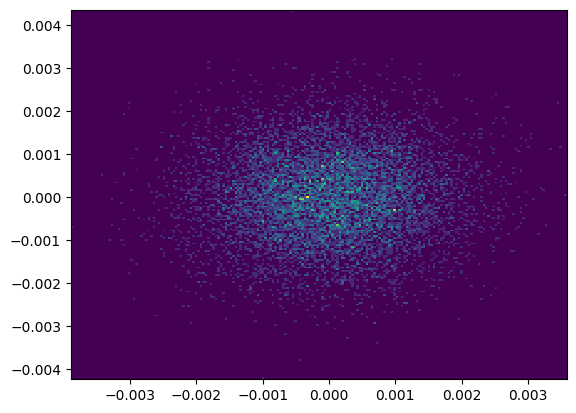

In [5]:
# initial y-py phase space
plt.hist2d(incoming_beam.particles[0,:,2], incoming_beam.particles[0,:,3], bins=200)
plt.show()

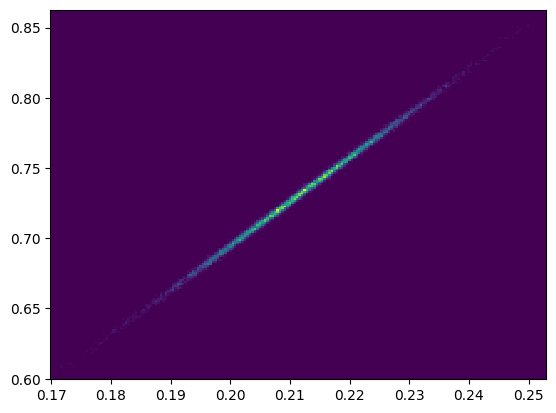

In [6]:
# Cheetah tracking method output y-py phase space: no chromatic aberration
plt.hist2d(cheetah_default_outgoing_beam.particles[0,:,2], cheetah_default_outgoing_beam.particles[0,:,3], bins=200)
plt.show()

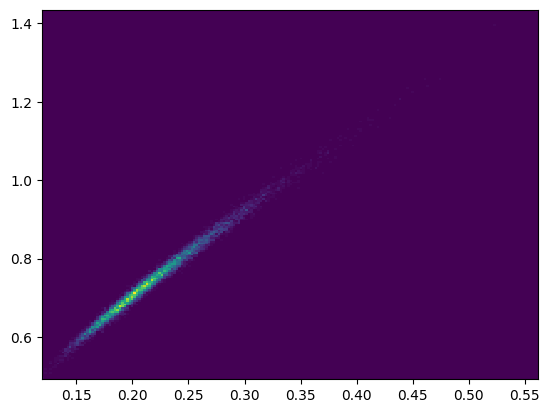

In [7]:
# bmadx tracking method output y-py phase space: chromatic effects:
plt.hist2d(cheetah_bmadx_outgoing_beam.particles[0,:,2], cheetah_bmadx_outgoing_beam.particles[0,:,3], bins=200)
plt.show()

In [8]:
# compare against bmadx library
from bmadx.bmad_torch.track_torch import Beam, TorchQuadrupole, TorchLattice
bmadx_beam = Beam(
    data=bmad_coords,
    p0c=p0c,
    mc2=mc2
)
bmadx_quad = TorchQuadrupole(L=l_quad, K1=k1_quad, X_OFFSET=offsets[0], Y_OFFSET=offsets[1], TILT=tilt, NUM_STEPS=10)
bmadx_lattice = TorchLattice([bmadx_quad])
bmadx_out_coords = torch.stack(bmadx_lattice(bmadx_beam)[:6], dim=-1)
bmadx_out_with_cheetah_coords, ref_energy = bmad_to_cheetah_coords(bmadx_out_coords, p0c, mc2)

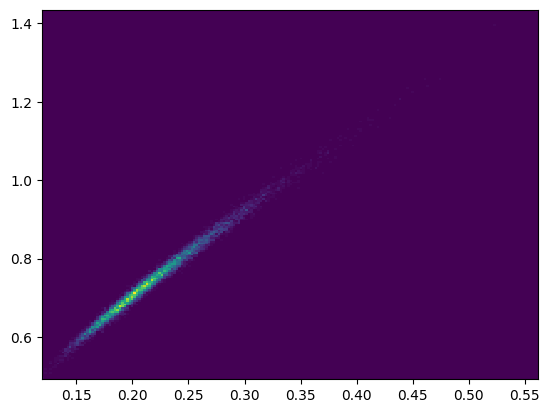

In [9]:
# bmadx library\ tracking output y-py phase space: chromatic effects:
plt.hist2d(bmadx_out_with_cheetah_coords[0,:,2], bmadx_out_with_cheetah_coords[0,:,3], bins=200)
plt.show()

In [18]:
# compare against cheetah with bmadx tracking method (expected to be the same)
print(torch.allclose(bmadx_out_with_cheetah_coords, cheetah_bmadx_outgoing_beam.particles, atol=1e-7, rtol=1e-7))
# for some reason, bmadx results only agree to single precision. 

True


In [11]:
# compare against cheetah with default tracking method (expected to be significantly different)
print(torch.allclose(bmadx_out_with_cheetah_coords, cheetah_default_outgoing_beam.particles, atol=1e-2, rtol=1e-1))

False


In [19]:
# save tensors for tests
#torch.save(incoming_beam, "incoming_beam.pt")
#torch.save(bmadx_out_with_cheetah_coords, "bmadx_out_with_cheetah_coords.pt")